In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
from PIL import Image
from IPython.display import display

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

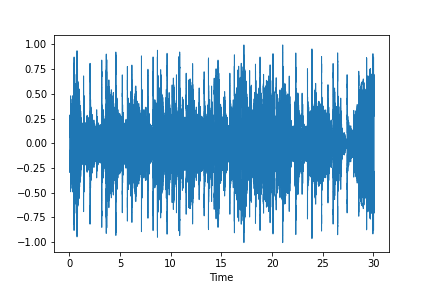

(432, 288)


In [3]:
# try to get one of the images inside the file
with Image.open('wavelets/train/rock/11.png') as im:
    display(im)
    print(im.size)

In [4]:
transform = transforms.ToTensor()
root ="wavelets"

train_data = datasets.ImageFolder(os.path.join(root,"train"), transform= transform)
test_data = datasets.ImageFolder(os.path.join(root, "test"), transform = transform)

torch.manual_seed(30)

train_loader = DataLoader(train_data, batch_size=10,shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

class_names = train_data.classes

In [5]:
class_names

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [6]:
len(train_data)

599

In [7]:
len(test_data)

400

Labels:  [1 7 3 5 9 9 6 8 2 2]
Class:  classical pop disco jazz rock rock metal reggae country country


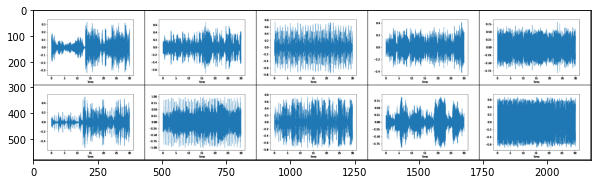

In [8]:
for images, labels in train_loader:
    break
    

print('Labels: ', labels.numpy())
print('Class: ',*np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [9]:
images[0].shape

torch.Size([3, 288, 432])

In [10]:
print((((288-2)/2)-2)/2)
print(((430/2)-2)/2)
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, 1)  
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(70*106*16, 120)   
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1,70*106*16) # flatten
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

70.5
106.5


In [11]:
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=118720, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [12]:
for param in model.parameters():
    print(param.numel())

450
6
864
16
14246400
120
10080
84
840
10


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001) ## stochiastic gradient descent

In [17]:
import time
start_time = time.time()

epochs = 3

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%10 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed   

epoch:  0  batch:   10 [   100/8000]  loss: 0.00023284  accuracy: 100.000%
epoch:  0  batch:   20 [   200/8000]  loss: 0.00016026  accuracy: 100.000%
epoch:  0  batch:   30 [   300/8000]  loss: 0.00023301  accuracy: 100.000%
epoch:  0  batch:   40 [   400/8000]  loss: 0.00046511  accuracy: 100.000%
epoch:  0  batch:   50 [   500/8000]  loss: 0.00007961  accuracy: 100.000%
epoch:  0  batch:   60 [   600/8000]  loss: 0.00013303  accuracy:  99.833%
epoch:  1  batch:   10 [   100/8000]  loss: 0.00037692  accuracy: 100.000%
epoch:  1  batch:   20 [   200/8000]  loss: 0.00039833  accuracy: 100.000%
epoch:  1  batch:   30 [   300/8000]  loss: 0.00024946  accuracy: 100.000%
epoch:  1  batch:   40 [   400/8000]  loss: 0.00043395  accuracy: 100.000%
epoch:  1  batch:   50 [   500/8000]  loss: 0.00017249  accuracy: 100.000%
epoch:  1  batch:   60 [   600/8000]  loss: 0.00019481  accuracy:  99.833%
epoch:  2  batch:   10 [   100/8000]  loss: 0.00037001  accuracy: 100.000%
epoch:  2  batch:   20 [ 